**Sentiment analaysis**

In [13]:
# Dataset

from google.colab import drive
import pandas as pd
import numpy as np

drive.mount("/content/drive")

y_names = ["negative", "positive"]

# Sentiment Labelled Sentences Data Set from the UCI (University of California Irvine) Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
dataset = pd.read_csv("/content/drive/My Drive/data/sentiment labelled sentences/yelp_labelled.txt", sep="\t", names=y_names)

y = np.array(dataset.get(y_names[1]).tolist())
raw_dataset = dataset.get(y_names[0]).tolist()

print("Number of (raw) documents:", len(raw_dataset))
print("Labels:", y_names)
print("First label values:", y[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of (raw) documents: 1000
Labels: ['negative', 'positive']
First label values: [1 0 0 1 1]


In [14]:
# Text preprocessing

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

dataset = []
stemmer = SnowballStemmer("english")
stopwords_en = stopwords.words("english")

for i in range(0, len(raw_dataset)):  
  tokens = regexp_tokenize(str(raw_dataset[i]), r"\w+")
  stems = [stemmer.stem(token) for token in tokens]
  words_no_stopwords = [word for word in stems if word not in stopwords_en]
  document = ' '.join(words_no_stopwords)
  dataset.append(document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Feature extraction (converting text to vectors)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset).toarray()

In [16]:
# Exploratory analysis

vocabulary_size = X.shape[1]
number_of_classes = len(y_names)

print("Number of (preprocessed) documents:", len(dataset))
print("Vocabulary size:", vocabulary_size)
print("Number of classes:", number_of_classes)
print("Vectorized dataset (number of documents, vocabulary size):", X.shape)

Number of (preprocessed) documents: 1000
Vocabulary size: 1575
Number of classes: 2
Vectorized dataset (number of documents, vocabulary size): (1000, 1575)


In [17]:
# Split training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (800, 1575)
Test set shape: (200, 1575)


In [18]:
# Create model

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=vocabulary_size, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                15760     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 15,857
Trainable params: 15,857
Non-trainable params: 0
_________________________________________________________________


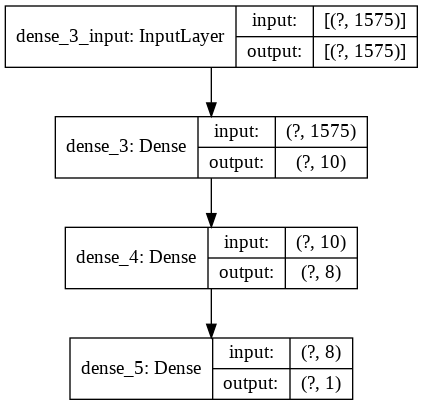

In [19]:
# Plot model

from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
# Fit model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=75, batch_size=10, verbose=False)

In [21]:
# Evaluate model

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9937
Testing Accuracy:  0.7550


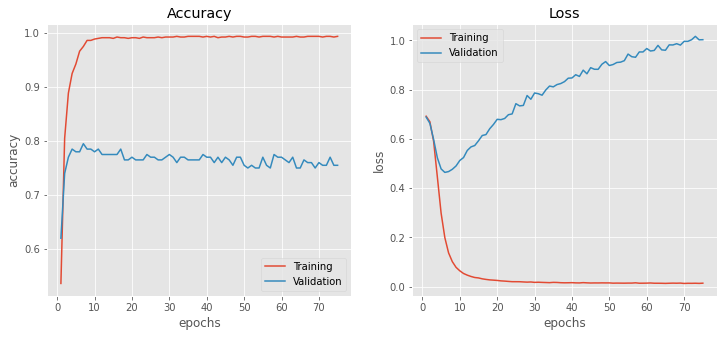

In [25]:
# Plot loss and accuracy for the training and testing data 

import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  x = range(1, len(acc) + 1)
  plt.style.use("ggplot")
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(x, acc, label="Training")
  plt.plot(x, val_acc, label="Validation")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, label="Training")
  plt.plot(x, val_loss, label="Validation")
  plt.title("Loss")
  plt.legend()
  plt.xlabel("epochs")
  plt.ylabel("loss")

plot_history(history)

In [ ]:
# Predict unseen data

unseen_sentence = input("Enter a sentence: ")
X_unseen = vectorizer.transform([unseen_sentence]).toarray()

y_unseen = np.argmax(model.predict(X_unseen), axis=-1) # Equivalent to: y_unseen = model.predict_classes(X_unseen)
print("The pedicted class for that sentence is:", y_names[y_unseen[0]])

Enter a sentence: This is very bad
The pedicted class for that sentence is: negative


In [ ]:
# Savel model

import h5py

model_structure = model.to_json()

with open("sentiment_analysis_model.json", "w") as json_file:
  json_file.write(model_structure)

model.save_weights("sentiment_analysis_weights.h5")

In [ ]:
# Load model

from keras.models import model_from_json

with open("sentiment_analysis_model.json", "r") as json_file:
  loaded_model = model_from_json(json_file.read())

loaded_model.load_weights("sentiment_analysis_weights.h5")

loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

loss, accuracy = loaded_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9937
Testing Accuracy:  0.7450
